In [1]:
#Import IPython to clear output and render Html
from IPython.display import HTML , clear_output
clear_output()


In [2]:
#Import dependencies
from PIL import Image
import cv2
import pytesseract
import numpy as np
import re
from pytesseract import Output

In [7]:
! pip install requests
import requests
clear_output()

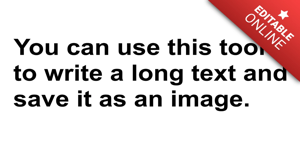

In [10]:
image = Image.open(requests.get("https://cdn.textstudio.com/output/preset/preview/large/0/5/7/8/875_86f27.webp", stream=True).raw)
image = image.resize((300,150))
image.save("sample.png")
image

In [15]:
#Extracting text from image -- using image_to_string()
custom_config = r"-l eng --oem 3 --psm 6"
text = pytesseract.image_to_string(image,config=custom_config)
print(text)

You can use ins to
to write a long text an
save it as an image.



In [20]:
#Code block to extract text then remove unnecesary symbols
try:
  text = pytesseract.image_to_string(image,lang="eng")
  characters_to_remove = "!()@-*~|_^&$#+><%"
  new_string = text
  for character in characters_to_remove:
    new_string = new_string.replace(character, "")
  print(new_string)
except IOError as e:
  print("Error (%s) " % e)


You can use this to
to write a long text an
save it as an image.



In [22]:
 #Now read the image using open-cv
image = cv2.imread("sample.png")

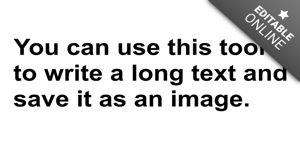

In [25]:
#define a function that converts image to grayscale
def get_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray = get_grayscale(image)
Image.fromarray(gray)

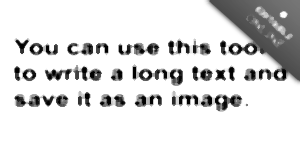

In [30]:
#Now remove noise from picture -- using medianBlur
def noise_removal(image):
  return cv2.medianBlur(image,5)
noise_removed = noise_removal(gray)
Image.fromarray(noise_removed)

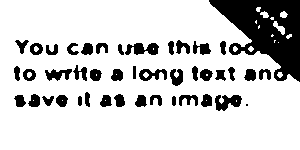

In [31]:
 #Now we perfom thresholding
def thresholding(image):
  return cv2.threshold(image,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]#1 returns image and 0 returns threshold value used
thresh = thresholding(noise_removed)
Image.fromarray(thresh)

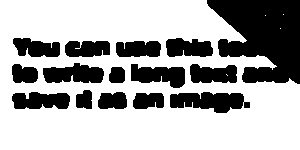

In [32]:
#erosion 
def erode(image):
  kernel = np.ones((5,5),np.uint8)
  return cv2.erode(image,kernel,iterations=1)
erode = erode(thresh)
Image.fromarray(erode)

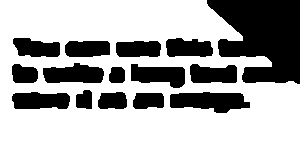

In [33]:
#Morphology --- opening
def opening(image):
  kernel = np.ones((5,5),np.uint8)
  return cv2.morphologyEx(image,cv2.MORPH_OPEN,kernel)
opened = opening(erode)
Image.fromarray(opened)

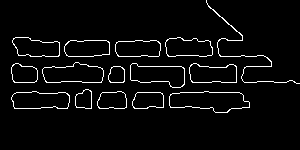

In [34]:
#Apply canny algorithm
def canny(image):
  return cv2.Canny(image,100,200)
after_canny = canny(opened)
Image.fromarray(after_canny)

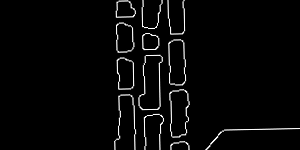

In [38]:
#deskewing
def deskew(image):
  coords = np.column_stack(np.where(image > 0))
  angle = cv2.minAreaRect(coords)[-1]
  if angle < -45:
    angle = -(90 + angle)
  else:
    angle = -angle
  (h,w) = image.shape[:2]
  center = (w//2,h//2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  rotated = cv2.warpAffine(image, M, (w,h), flags=cv2.INTER_CUBIC , borderMode=cv2.BORDER_REPLICATE)
  return rotated
rotated = deskew(after_canny)
Image.fromarray(rotated)

In [41]:
#Template matching 
def match_template(image,template):
  return cv2.matchTemplate(image,template,cv2.TM_CCOEFF_NORMED)
matched = match_template(rotated,rotated)
matched

array([[1.]], dtype=float32)

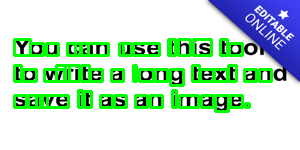

In [42]:
#Drawing rectangles around the text
img = cv2.imread("sample.png")
h,w,c = img.shape
boxes = pytesseract.image_to_boxes(img)
for b in boxes.splitlines():
  b = b.split(' ')
  img  = cv2.rectangle(img,(int(b[1]),h - int(b[2])),(int(b[3]),h-int(b[4])),(0,255,0),2)
Image.fromarray(img)

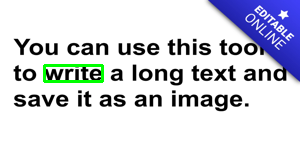

In [45]:
#Drawing a rectangle on a specific pattern
img = cv2.imread("sample.png")
d = pytesseract.image_to_data(img, output_type=Output.DICT)
keys = list(d.keys())

data_pattern = 'write'

n_boxes = len(d['text'])
for i in range(n_boxes):
  if int(d['conf'][i]) > 60:  # Confidence threshold
    if re.match(data_pattern, d['text'][i]):
      (x, y, w, h) = (d['left'][i], d['top'][i],d['width'][i],d['height'][i])
      img = cv2.rectangle(img, (x,y),(x+w,y+h),(0,255,0),2)

Image.fromarray(img)
